# Neural Style Transfer Exp:3
Context [here](https://dhruvs.space/posts/neural-style-transfer/).

Things explored:
- Reconstruction GIFs for different paintings


In [0]:
from google.colab import drive
drive.mount('/content/gdrive')
DRIVE_BASE_PATH = "/content/gdrive/My\ Drive/Colab\ Notebooks/"

In [0]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [0]:
!pip install -q fastai==0.7.0 torchtext==0.2.3

In [0]:
from fastai.conv_learner import *
from pathlib import Path
from scipy import ndimage
from math import ceil
from decimal import Decimal
from IPython.display import HTML

In [0]:
class SaveFeatures():
    features=None
    def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): self.features = output
    def close(self): self.hook.remove()

In [0]:
class NeuralStyleTransfer(object):
    
    def __init__(self,base_model,sz):
        self.base_model = base_model
        self.sz = sz
        self.model = to_gpu(base_model(True)).eval()
        set_trainable(self.model, False)
        self.trn_tfms,self.val_tfms = tfms_from_model(self.base_model, self.sz)
        
    def get_opt(self,img):
        opt_img = np.random.uniform(0, 1, size=img.shape).astype(np.float32)
        opt_img = scipy.ndimage.filters.median_filter(opt_img, [8,8,1])
        opt_img_v = V(self.val_tfms(opt_img/2)[None], requires_grad=True)
        return opt_img_v, optim.LBFGS([opt_img_v])
    
    def step(self,loss_fn):
        self.optimizer.zero_grad()
        loss = loss_fn(self.opt_img_v)
        loss.backward()
        self.n_iter+=1
#         if self.print_losses:
#             if self.n_iter%self.show_iter==0: print(f'Iteration: {self.n_iter}, loss: {loss.data[0]}')
        return loss

    def scale_match(self, src, targ):
        h,w,_ = src.shape
        sh,sw,_ = targ.shape
        rat = max(h/sh,w/sw); rat
        res = cv2.resize(targ, (int(sw*rat), int(sh*rat)))
        return res[:h,:w]
    
    def gram(self,input):
        b,c,h,w = input.size()
        x = input.view(b*c, -1)
        return torch.mm(x, x.t())/input.numel()*1e6

    def gram_mse_loss(self,input, target):
        return F.mse_loss(self.gram(input), self.gram(target))
    
    def comb_loss(self,x):
        self.model(self.opt_img_v)
        content_outs = [V(o.features) for o in self.content_sfs]
        style_outs = [V(o.features) for o in self.style_sfs]
        
#         content_loss
        content_losses   = [F.mse_loss(o, s) 
                        for o,s in zip(content_outs, self.targ_vs)]
    
#         style_loss
        style_losses = [self.gram_mse_loss(o, s) 
                        for o,s in zip(style_outs, self.targ_styles)]

    
        if self.content_layers_weights is None:
            content_loss = sum(content_losses)
        else:
            content_loss = sum([a*b for a,b in 
                                zip(content_losses,self.content_layers_weights)])
            
        if self.style_layers_weights is None:
            style_loss = sum(style_losses)
        else:
            style_loss = sum([a*b for a,b in 
                              zip(style_losses,self.style_layers_weights)])
        if self.print_losses:
            if self.n_iter%self.show_iter==0:
                print(f'content: {self.alpha*content_loss.data[0]}, style: {self.beta*style_loss.data[0]}')
        
        if self.return_intermediates and self.n_iter<=self.gif_iter_till:
            if self.n_iter%self.gif_iter==0:
                self.intermediate_images.append(self.val_tfms.denorm(np.rollaxis(to_np(self.opt_img_v.data),1,4))[0])
        
        return self.alpha*content_loss + self.beta*style_loss

    def generate(self, content_image, style_img,
                 style_layers, content_layers,
                 alpha=1e6,
                 beta=1.,
                 content_layers_weights=None,
                 style_layers_weights=None,
                 max_iter=500,show_iter=300,
                 print_losses=False,
                 scale_style_img=True,
                 return_intermediates=False,
                 gif_iter=50,
                 gif_iter_till=500):
        
        self.max_iter = max_iter
        self.show_iter = show_iter
        self.gif_iter = gif_iter
        self.gif_iter_till = gif_iter_till
        
        self.alpha = alpha
        self.beta = beta
        self.content_layers_weights = content_layers_weights
        self.style_layers_weights = style_layers_weights
        self.print_losses = print_losses
        self.return_intermediates = return_intermediates
        self.intermediate_images = []

        self.content_sfs = [SaveFeatures(children(self.model)[idx]) for idx in content_layers]
        
        self.style_sfs = [SaveFeatures(children(self.model)[idx]) for idx in style_layers]
        
#         get target content
        img_tfm = self.val_tfms(content_image)
        self.opt_img_v, self.optimizer = self.get_opt(content_image)
        self.model(VV(img_tfm[None]))
        self.targ_vs = [V(o.features.clone()) for o in self.content_sfs]

#         get target style
        if scale_style_img:
            style_img = self.scale_match(content_image, style_img)
        self.style_tfm = self.val_tfms(style_img)
        self.model(VV(self.style_tfm[None]))
        self.targ_styles = [V(o.features.clone()) for o in self.style_sfs]
        
        self.n_iter=0

        while self.n_iter <= self.max_iter: self.optimizer.step(partial(self.step,self.comb_loss))
        for sf in self.content_sfs: sf.close()
        for sf in self.style_sfs: sf.close()
        if not self.return_intermediates:
            return self.val_tfms.denorm(np.rollaxis(to_np(self.opt_img_v.data),1,4))[0]
        else:
            return self.intermediate_images

In [0]:
PATH = Path('data/imagenet')
PATH_IMAGES = PATH/'images'
PATH_STYLE = PATH/'style'

!mkdir -p {PATH_IMAGES}
!mkdir -p {PATH_STYLE}

!wget -qq http://farm1.static.flickr.com/202/480492895_711231246a.jpg -O {PATH_IMAGES}/farm.jpg
content_img = open_image(PATH_IMAGES/'farm.jpg')

# # !wget -qq https://media.overstockart.com/optimized/cache/data/product_images/VG1540-1000x1000.jpg -O {PATH_STYLE}/'cafe_terrace.jpg'
# style_img = open_image(PATH_STYLE/'cafe_terrace.jpg')

# images = [content_img,style_img]
# titles = ['content image', 'style image']

# fig,axes = plt.subplots(1,2,figsize=(10,5))
# for i,ax in enumerate(axes.flat):
#     ax.grid(False)
#     ax.get_xaxis().set_visible(False)
#     ax.get_yaxis().set_visible(False)
#     ax.set_title(titles[i])
#     ax.imshow(images[i]);
# plt.tight_layout()
# plt.show()

In [0]:
t2 = NeuralStyleTransfer(vgg16,288)

In [0]:
t2.model

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (2): ReLU(inplace)
  (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (5): ReLU(inplace)
  (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
  (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
  (9): ReLU(inplace)
  (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
  (12): ReLU(inplace)
  (13): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
  (14): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
  (16): ReLU(inplace)
  (17): Conv2d(256, 256, ke

!wget -qq "https://cdn.shopify.com/s/files/1/0223/4033/products/V495_bfc78f33-3b1a-40ec-bd64-f85c4ec05fa4_1024x1024.jpg" -O data/imagenet/style/van_gogh_self_portrait.jpg
!wget -qq "https://upload.wikimedia.org/wikipedia/commons/thumb/0/0a/The_Great_Wave_off_Kanagawa.jpg/1024px-The_Great_Wave_off_Kanagawa.jpg" -O data/imagenet/style/kanagawa_wave.jpg
!wget -qq "https://images-na.ssl-images-amazon.com/images/I/81Z7qbHAjDL._SY679_.jpg" -O data/imagenet/style/the_scream.jpg
!wget -qq "http://cdn.artobserved.com/2009/03/vincent-van-gogh-the-night-cafe-1888-via-artstor-collections.jpg" -O data/imagenet/style/the_night_cafe.jpg


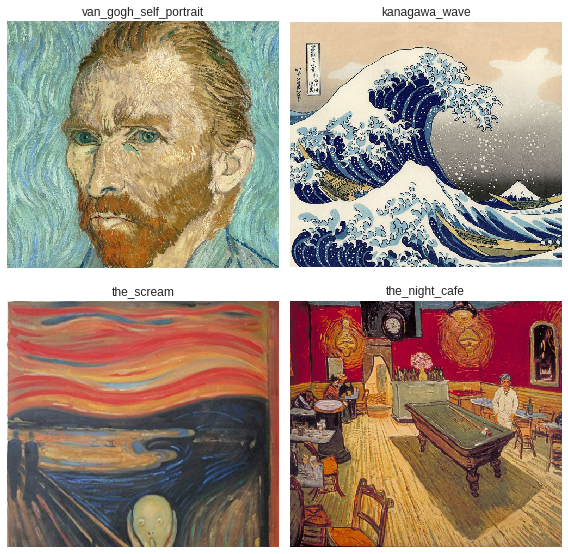

In [10]:
paintings = {
    "van_gogh_self_portrait":"https://cdn.shopify.com/s/files/1/0223/4033/products/V495_bfc78f33-3b1a-40ec-bd64-f85c4ec05fa4_1024x1024.jpg",
    "kanagawa_wave":"https://upload.wikimedia.org/wikipedia/commons/thumb/0/0a/The_Great_Wave_off_Kanagawa.jpg/1024px-The_Great_Wave_off_Kanagawa.jpg",
    "the_scream":"https://images-na.ssl-images-amazon.com/images/I/81Z7qbHAjDL._SY679_.jpg",
    "the_night_cafe":"http://cdn.artobserved.com/2009/03/vincent-van-gogh-the-night-cafe-1888-via-artstor-collections.jpg"
}

for painting in paintings:
    print(f'!wget -qq "{paintings[painting]}" -O {PATH_STYLE}/{painting}.jpg')
    !wget -qq "{paintings[painting]}" -O {PATH_STYLE}/{painting}.jpg
    
style_paintings = []
paintings_names = []

for painting in paintings:
    try:
        style_paintings.append(open_image(f'{PATH_STYLE}/{painting}.jpg'))
        paintings_names.append(painting)
    except Exception as e:
        print(str(e))
        
n_cols = 2
n_rows = ceil(len(style_paintings)/n_cols)

fig,axes = plt.subplots(n_rows,n_cols, figsize=(n_cols*4,n_rows*4))

for i,ax in enumerate(axes.flat):
        
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f'{paintings_names[i]}')
    ax.imshow(t2.scale_match(content_img, style_paintings[i]))
plt.tight_layout()
plt.show()

## Reconstruction GIFs for 4 paintings

In [0]:
def generate_anim(content_img, style_img,
                   gif_name,
                   content_layers=[16,22,26],
                   style_layers=[9,12,16,22,26],
                   alpha=1e5,
                   beta=3.,
                   style_layers_weights=None,
                   max_iter=800,show_iter=100,
                   print_losses=True,
                   scale_style_img=True,
                   return_intermediates=True,
                   gif_iter=10,
                   gif_iter_till=200):

    imgs = t2.generate(content_img, style_img,
                           content_layers=content_layers,
                           style_layers=style_layers,
                           alpha=alpha,
                           beta=beta,
                           style_layers_weights=style_layers_weights,
                           max_iter=max_iter,show_iter=show_iter,
                           print_losses=print_losses,
                           scale_style_img=scale_style_img,
                           return_intermediates=True,
                           gif_iter=gif_iter,
                           gif_iter_till=gif_iter_till)

    fig, ax = plt.subplots(figsize=(5,5))
    ax.grid(False)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    fig.tight_layout()
    ims = []
    for i,img in enumerate(imgs):
        txt = plt.text(10,15,f'{i*gif_iter}',color='white', fontsize=16, weight='bold')
        im = ax.imshow(np.clip(img, 0, 1), interpolation='lanczos', animated=True)

        ims.append([im,txt])

    ani = animation.ArtistAnimation(fig, ims, interval=300, blit=True,
                                repeat=False)
    plt.close()
#     ani.save(gif_name, writer='imagemagick', fps=2)
    return ani

In [31]:
ani0 = generate_anim(content_img,style_paintings[0],'1',gif_iter_till=250)
HTML(ani0.to_html5_video())

content: 4590.15853703022, style: 38485.1630859375
content: 1405.3253456950188, style: 423.72459411621094
content: 977.1265089511871, style: 260.5838928222656
content: 881.5128356218338, style: 242.66610717773438
content: 841.5341377258301, style: 236.9879150390625
content: 819.4843307137489, style: 233.7857666015625
content: 804.8317395150661, style: 232.1699981689453
content: 794.0953597426414, style: 231.28431701660156
content: 786.1829362809658, style: 230.86072540283203


In [32]:
ani1 = generate_anim(content_img,style_paintings[1],'1',gif_iter_till=250)
HTML(ani1.to_html5_video())

content: 4575.74725151062, style: 64045.171875
content: 3122.0929697155952, style: 1746.3153076171875
content: 2585.234120488167, style: 1037.5933227539062
content: 2288.0855947732925, style: 835.9627990722656
content: 2089.9783819913864, style: 732.6463623046875
content: 1952.7720287442207, style: 677.1790008544922
content: 1867.5468862056732, style: 643.358642578125
content: 1803.5780638456345, style: 620.6485748291016
content: 1754.583977162838, style: 603.0455474853516


In [33]:
ani2 = generate_anim(content_img,style_paintings[2],'2',gif_iter_till=300)
HTML(ani2.to_html5_video())

content: 4592.237249016762, style: 17825.0068359375
content: 2139.442041516304, style: 1034.8515930175781
content: 1610.0019216537476, style: 639.3570556640625
content: 1408.0935157835484, style: 504.5973358154297
content: 1312.5848025083542, style: 446.3579406738281
content: 1261.8070468306541, style: 419.0742645263672
content: 1227.2853404283524, style: 404.75111389160156
content: 1206.3353322446346, style: 395.78810119628906
content: 1191.2132613360882, style: 389.9870910644531


In [35]:
ani3 = generate_anim(content_img,style_paintings[3],'3',gif_iter_till=300)
HTML(ani3.to_html5_video())

content: 4592.53117442131, style: 33575.5517578125
content: 1770.2260985970497, style: 539.7735900878906
content: 1359.0148650109768, style: 393.0853729248047
content: 1221.1107648909092, style: 371.0020751953125
content: 1156.4304120838642, style: 361.98584747314453
content: 1118.8853532075882, style: 356.82808685302734
content: 1094.9686169624329, style: 353.63108825683594
content: 1077.8657160699368, style: 351.01883697509766
content: 1065.5386373400688, style: 348.93143463134766


## Varying content and style layers

Content from `[19,22]`, style from `[16,22,26,29,32]`.

In [36]:
ani = generate_anim(content_img,style_paintings[3],'3',
                        content_layers=[19,22],
                        style_layers=[16,22,26,29,32],
                        alpha=1e5,
                        beta=3.,
                        gif_iter_till=400)
HTML(ani.to_html5_video())

content: 3469.8091447353363, style: 2290.3194580078125
content: 608.3235144615173, style: 308.0112991333008
content: 533.9357070624828, style: 284.6939163208008
content: 500.90113654732704, style: 277.01905059814453
content: 482.40646719932556, style: 273.54437255859375
content: 469.62746419012547, style: 271.52490234375
content: 459.5996346324682, style: 270.19569396972656
content: 451.5883047133684, style: 269.60611724853516
content: 445.7229748368263, style: 268.8666687011719
